In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import numpy as np
import warnings
import scipy as scipy
from scipy import optimize
from scipy.optimize import differential_evolution
from tqdm import tqdm
from matplotlib.pyplot import cm
from collections import OrderedDict
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
def gaussian(x, mu, sig, A):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

def target_array(line):
    array = pd.read_csv('../data/eclipse_guess.csv')
    target_mask = array.Species.str.endswith(line) #probably a better function but idk it right now
    array_line = array[target_mask]
    guess = array_line.to_numpy()

    C = np.delete(guess, 1, 1)
    C = np.delete(C, 1, 1)
    C = np.delete(C, 3, 1)
    C = np.delete(C, 3, 1)
    test = np.delete(C, 3, 1)

    df_test = pd.DataFrame(test, columns = ['Wavelength','Sigma','Amplitude'])
    df_test = df_test.dropna()
    test = df_test.to_numpy()
    return test, array_line

def fit_whole_spectra(array):
    params = np.zeros((len(test),3))
    for index in tqdm(range(0, len(array))):
        guess1 = test[index]
        optim = optimize.least_squares(errfunc1, guess1, args=(wl, flux),
                               bounds=([guess1[0]-0.01, 0, 0],[guess1[0]+0.01, guess1[1]+0.1, guess1[2]+3]))
        params[index] = optim['x']
        #global total_params
        
        plt.figure(figsize=(16, 5))
        plt.title('COS Io Spectrum: {} {}'.format(line, guess1[0]))
        plt.plot(wl, flux,'g.', label='measurement')
        plt.plot(wl, gaussian(wl, *params[index]),
            lw=2, c='red', ls='--', label='bounded fit')
        plt.ylim(-1,guess1[2]+100)
        plt.xlim(guess1[0]-3,guess1[0]+3)
        plt.legend(loc='best')
    return params

def species_plot(line):
    mu = params[:,0]
    sigma = params[:,1]
    amp = params[:,2]
    no_nans = array_line.dropna()
    os = no_nans['Oscillator Strength (gA)']
    m, b = np.polyfit(amp, os, 1)
    
    plt.figure(figsize=(16, 5))
    plt.title('Amplitude vs Oscillator Strength for {}'.format(line))
    plt.xlabel('Amplitude ($erg/s/cm^2/\AA$)')
    plt.ylabel('Oscillator Strength ($g_kA_{ki}$)')
    plt.plot(amp, os,'g.', label='measurement')
    plt.plot(amp, m*amp + b)
    plt.show()
    
def full_plot_per_species():
    total_g = 0
    for i in range(0,len(params)):
        total_g = total_g + gaussian(wl, *params[i])
    plt.figure(figsize=(16, 5))
    plt.title("Complete Gaussian Fitting of COS Io Spectrum for {}".format(line))
    plt.plot(wl, flux,'g.', label='measurement')
    plt.plot(wl, total_g,
            lw=2, c='red', ls='--', label='bounded fit')
    plt.ylim(-0.01,1500)
    plt.tight_layout()
    plt.show()
    save_place = '/Users/jojoa/GitHub/io_brightness/data/figures/total_gauss/'
    plt.savefig(save_place+"gauss_fit_{}.jpg".format(line), format="jpg",dpi=1000)
    
def total_spectrum_plot(total_params, c):
    total_params = np.delete(total_params, 0, 0) #remove row of zeros
    total_g = 0
    for i in range(0,len(total_params)):
        total_g = total_g + gaussian(wl, *total_params[i])
    plt.figure(figsize=(16, 5))
    plt.title("Complete Gaussian Fitting of COS Io Spectrum ")
    plt.plot(wl, flux,'g.', label='measurement')
    vertical_lines(lines)
    plt.plot(wl, total_g,
            lw=2, c=c, ls='-', label='bounded fit')
    plt.ylim(-10,1000)
    plt.tight_layout()
    plt.show()
    save_place = '/Users/jojoa/GitHub/io_brightness/data/figures/total_gauss/'
    #plt.savefig(save_place+"gauss_fit_total.jpg", format="jpg",dpi=1000)
    
def color_change(total_params):
    total_params = np.delete(total_params, 0, 0) #remove row of zeros
    total_g = 0
    plt.figure(figsize=(16, 5))
    plt.title("Color Coded Individual Fitting of COS Io Spectrum ")
    plt.plot(wl, flux,'g.', label='measurement')
    
    for i in range(0,length[1]):
        total_g = total_g + gaussian(wl, *total_params[i])
    plt.plot(wl, total_g,lw=1, c='red', label='S I')
    total_g = 0
    
    for i in range(length[1],length[1]+length[2]):
        total_g = total_g + gaussian(wl, *total_params[i])
    plt.plot(wl, total_g,lw=2, c='red', ls=':', label='S II')
    
    for i in range(length[1]+length[2],length[1]+length[2]+length[3]):
        total_g = total_g + gaussian(wl, *total_params[i])
    plt.plot(wl, total_g,lw=2, c='red', ls=':', label='S III')
    total_g = 0
    
    for i in range(length[1]+length[2]+length[3],length[1]+length[2]+length[3]+length[4]):
        total_g = total_g + gaussian(wl, *total_params[i])
    plt.plot(wl, total_g,lw=1, c='blue', ls='--', label='Cl I')
    total_g = 0
    
    for i in range(length[1]+length[2]+length[3]+length[4],len(total_params)):
        total_g = total_g + gaussian(wl, *total_params[i])
    plt.plot(wl, total_g,lw=1, c='orange', ls='--', label='O I')
    total_g = 0
    
    vertical_lines(lines)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.ylim(-0.01,1000)
    plt.tight_layout()
    save_place = '/Users/jojoa/GitHub/io_brightness/data/figures/total_gauss/'
    #plt.savefig(save_place+"color_coded_gauss_fit_individ.jpg", format="jpg",dpi=1000)
    
def vertical_lines(lines):
    colors = ['red','red','red','blue','orange']
    ls = ['solid','dotted','dotted','solid','solid']
    for i in range(0,len(lines)):
        line = lines[i]
        df=array[['Wavelength','Species']]
        target_mask = df.Species.str.endswith(line) #probably a better function but idk it right now
        df = df[target_mask]
        df_wavelength = df['Wavelength']
        wavelength_list = df_wavelength.values.tolist()
        for j in range(0,len(wavelength_list)):
                xc = wavelength_list[j]
                plt.axvline(x=xc, color = colors[i], linestyle = ls[i], lw=1, label = lines[i])
                handles, labels = plt.gca().get_legend_handles_labels()
                by_label = OrderedDict(zip(labels, handles))
                plt.legend(by_label.values(), by_label.keys())
                
def os_vs_brightness(x, y):
    plt.figure(figsize=(16, 5))
    plt.title('Brightness vs Oscillator Strength for {}'.format(line))
    plt.xlabel('Oscillator Strength ($g_kA_{ki}$)')
    plt.ylabel('Brightness')
    plt.plot(x, y,'g.', label='measurement')
    plt.show()
    
def brightness(total_params):
    total_params = np.delete(total_params, 0, 0) #remove row of zeros

    mu = total_params[:,0]
    sigma = total_params[:,1]
    amp = total_params[:,2]
    amp = amp
    brightness = ((2*np.pi)**.5)*(amp*sigma)
    
    s1 = brightness[0:length[1]]
    s2 = brightness[length[1]:length[1]+length[2]]
    s3 = brightness[length[1]+length[2]:length[1]+length[2]+length[3]]
    cl1 = brightness[length[1]+length[2]+length[3]:length[1]+length[2]+length[3]+length[4]]
    o1 = brightness[length[1]+length[2]+length[3]+length[4]:len(total_params)]

    b = [s1,s2,s3,cl1,o1]
    return b

In [3]:
hdulist = fits.open('../data/composite_Io_eclipsed (1).fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/eclipse_guess.csv') #spaces in csv file will make df object type and not float64

df_wavelength = df['Wavelength']
df_species = df['Species']
wl = evt_data['WAVELENGTH'].T
flux = evt_data['FLUX'].T
wl = wl.data
flux = flux.data
wl = wl.flatten()
flux = flux.flatten()

array = pd.read_csv('../data/eclipse_guess.csv') #spaces in csv file will make df object type and not float64
errfunc1 = lambda p, x, y: (gaussian(x, *p) - y)**2

lines = ['S I','S II', 'S III', 'Cl I', 'O I']
total_params = np.zeros((1,3))
length = [0]

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:03<00:00,  6.82it/s]


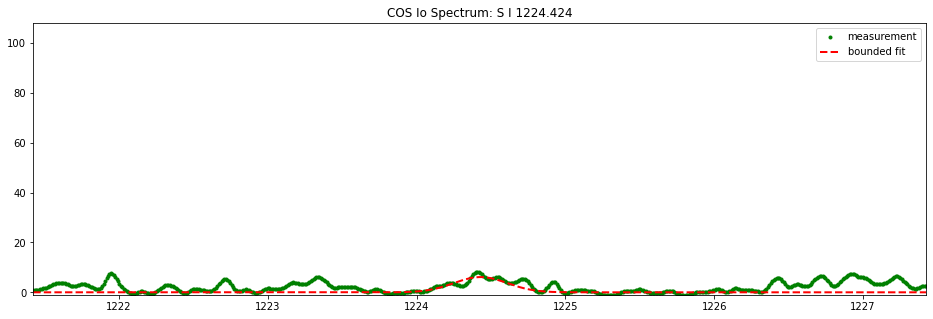

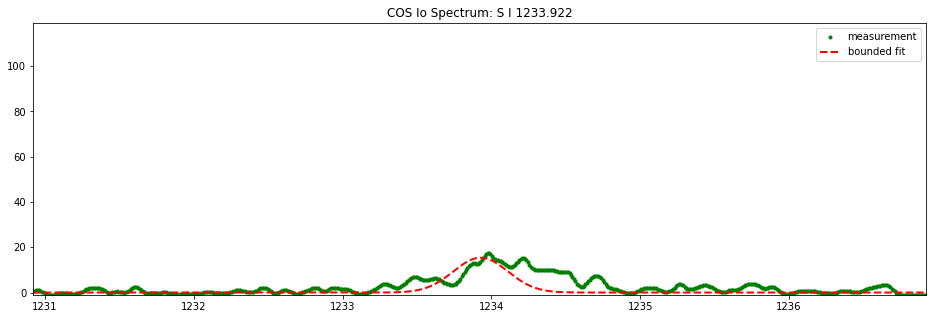

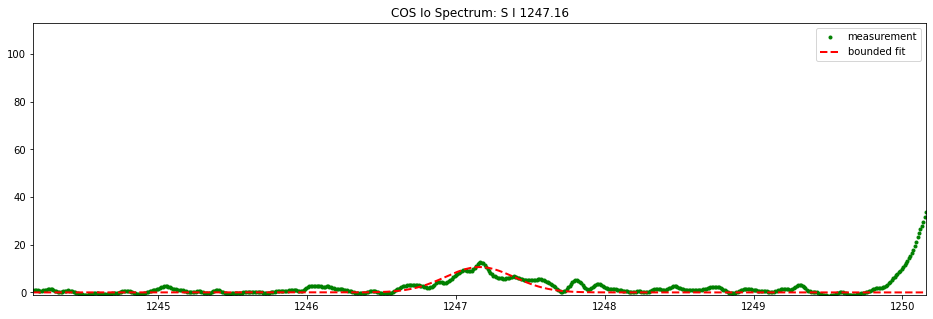

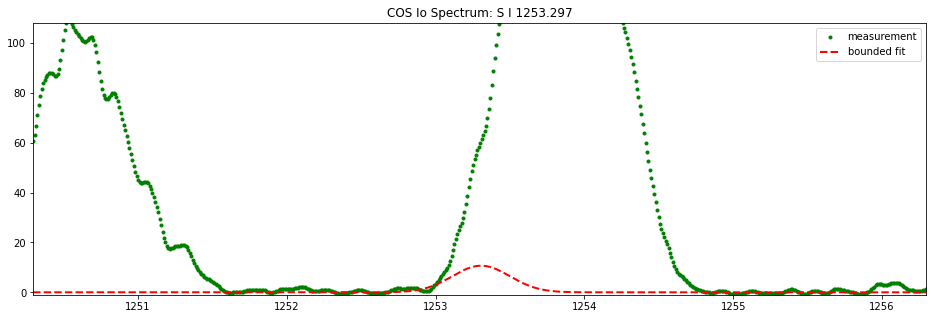

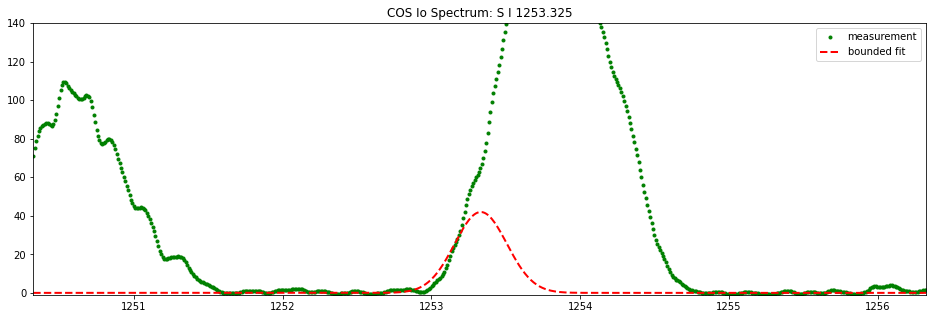

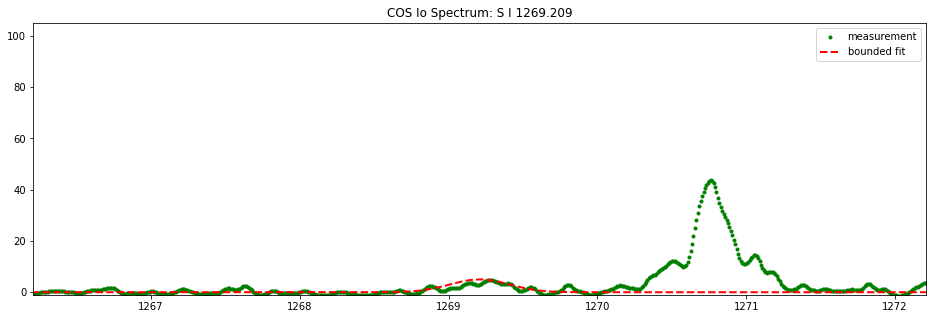

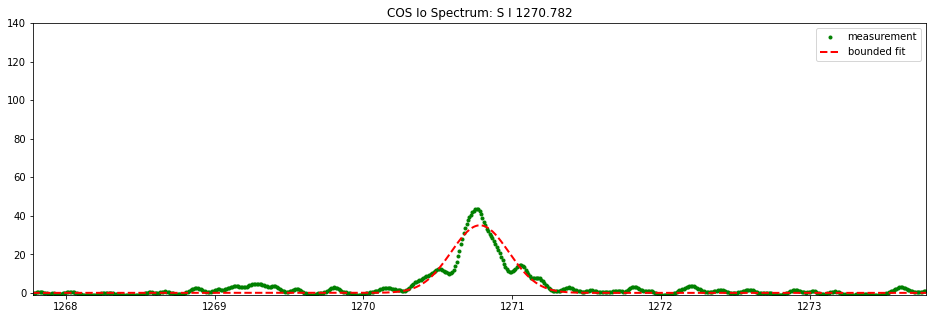

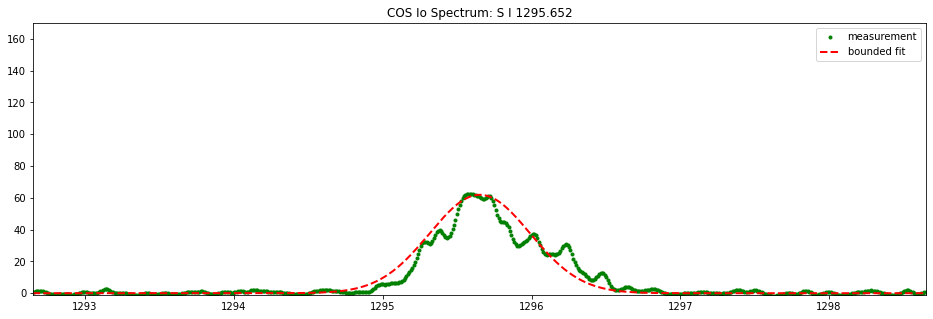

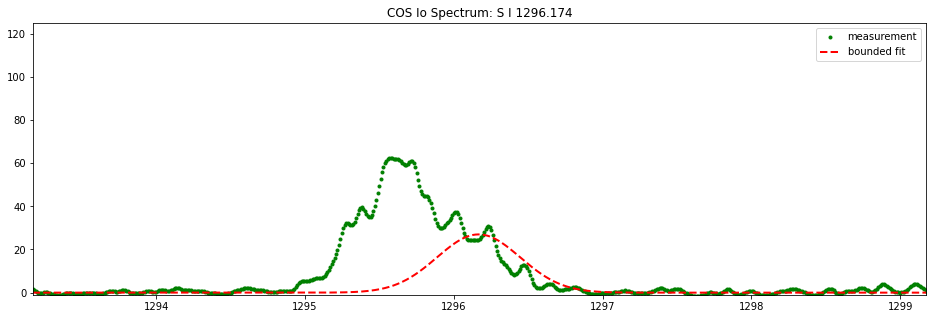

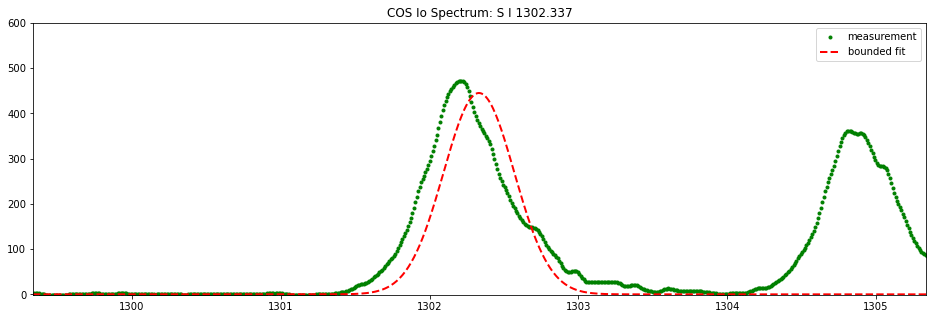

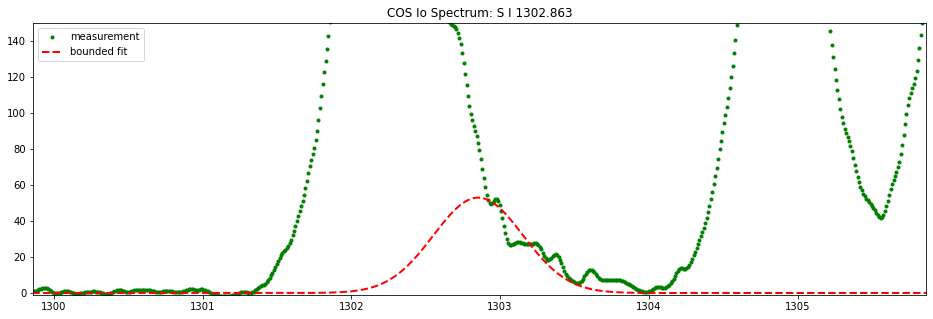

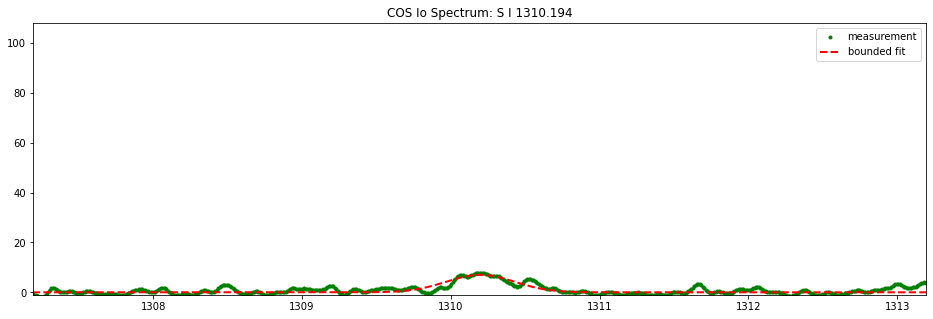

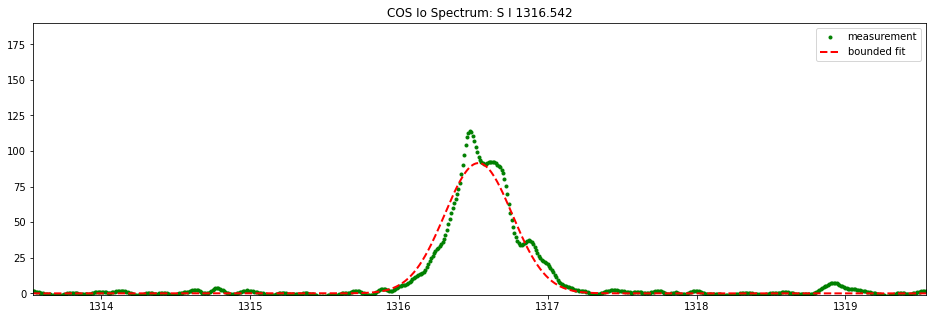

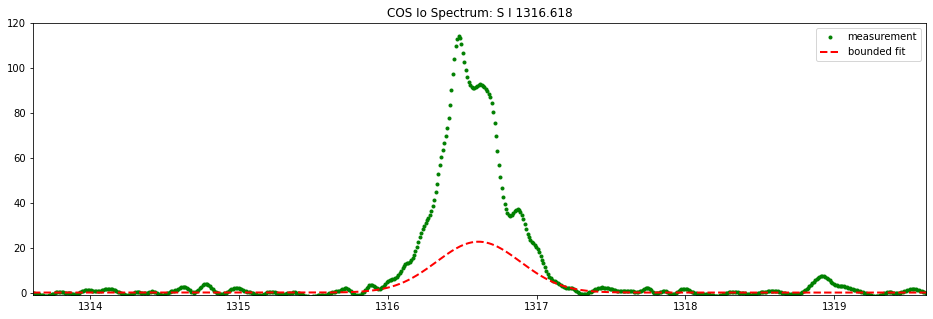

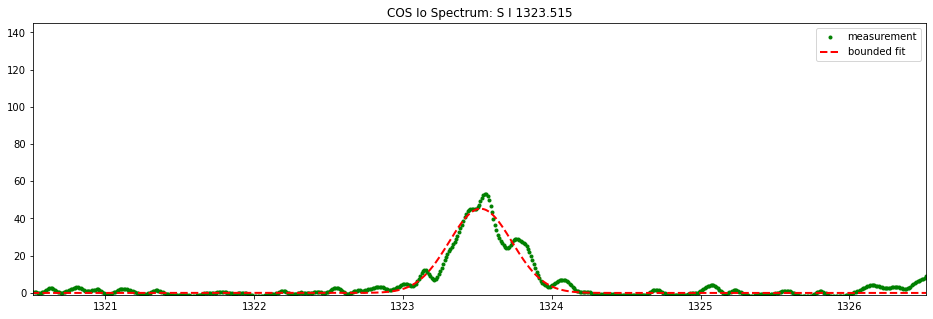

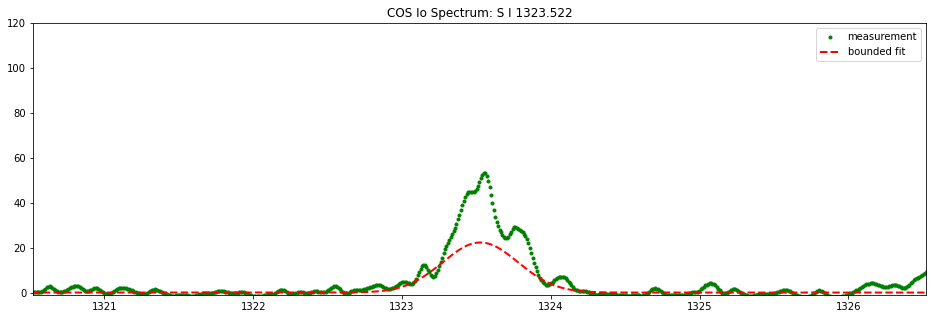

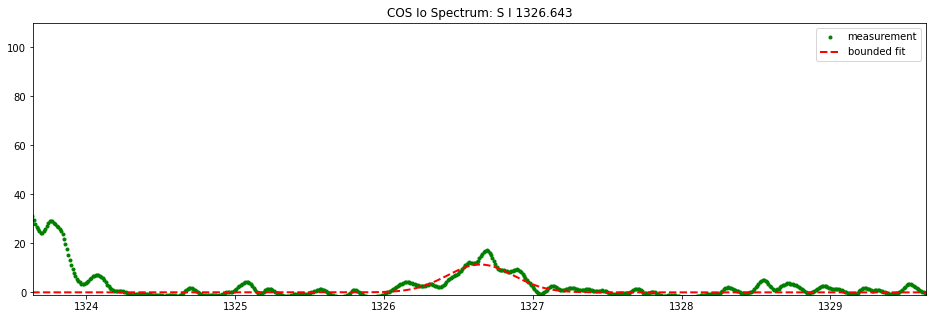

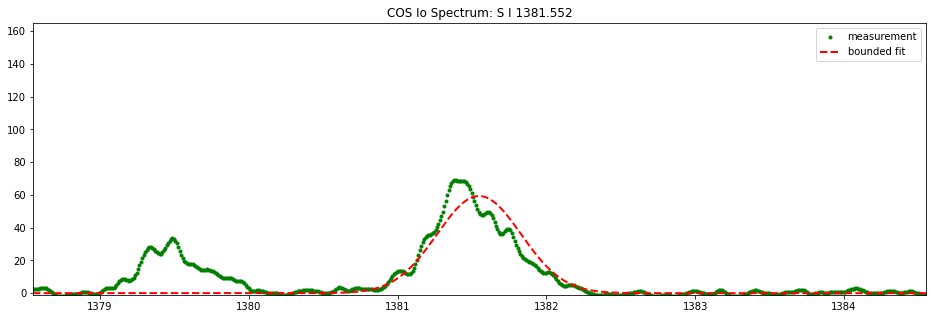

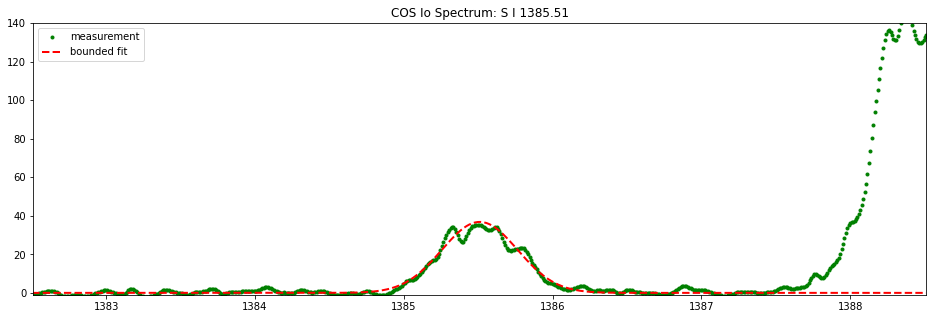

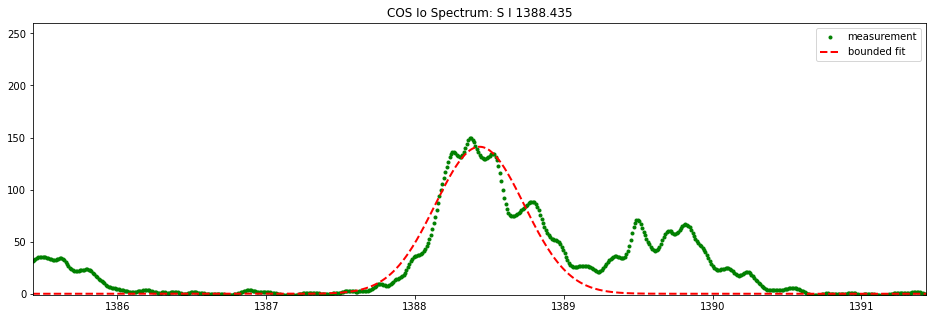

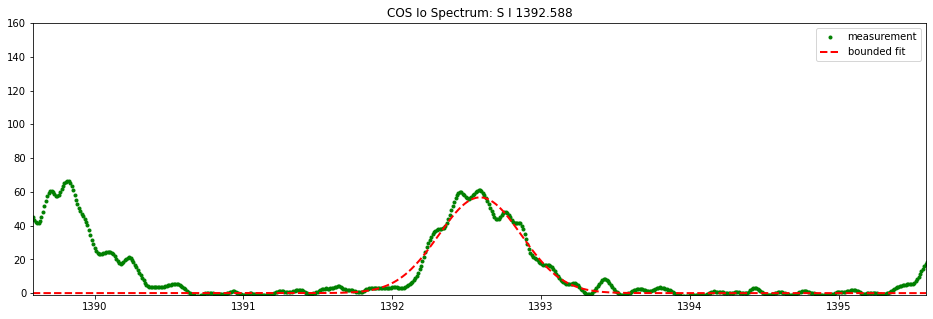

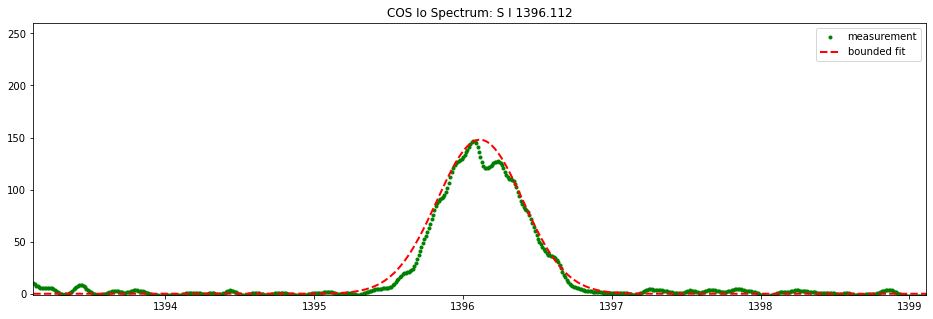

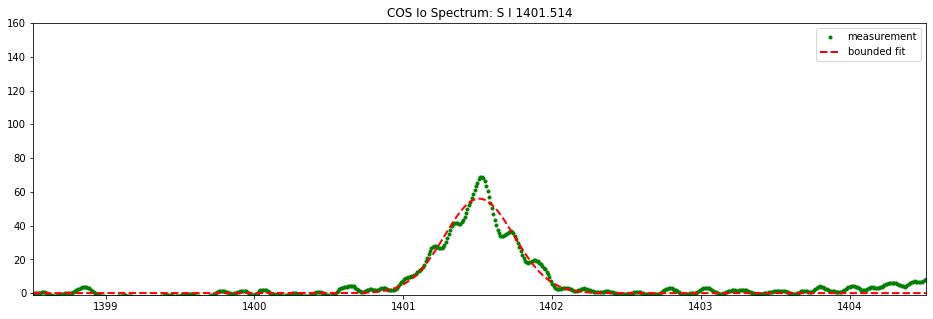

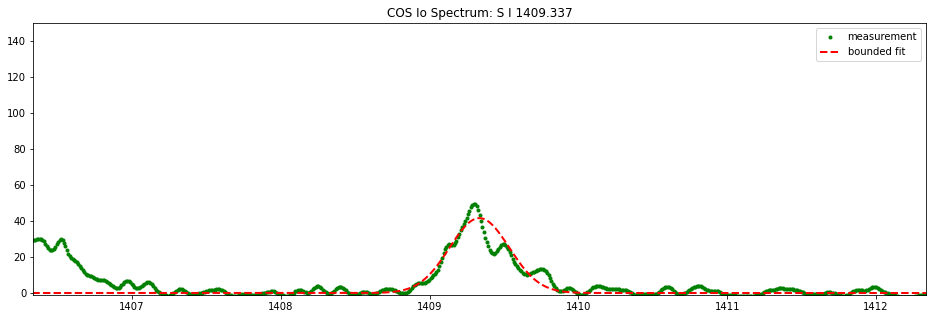

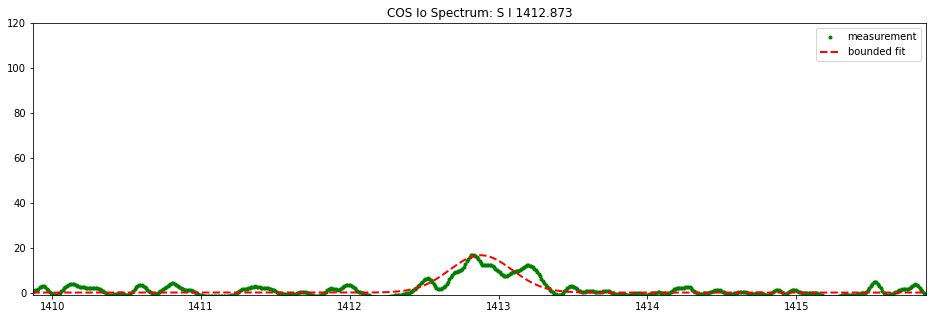

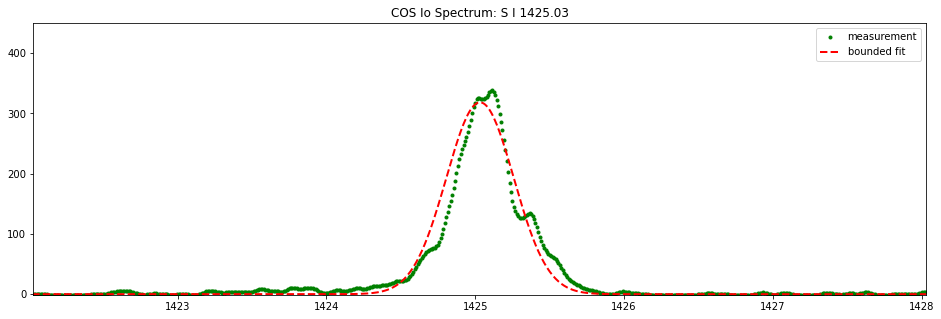

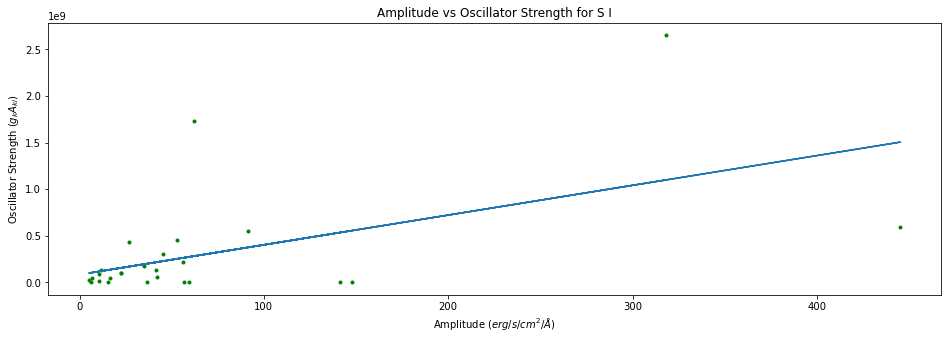

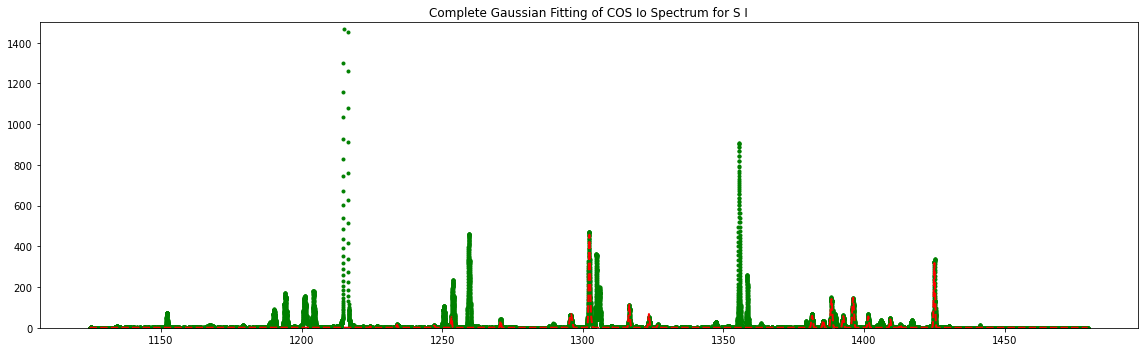

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.22it/s]


<Figure size 432x288 with 0 Axes>

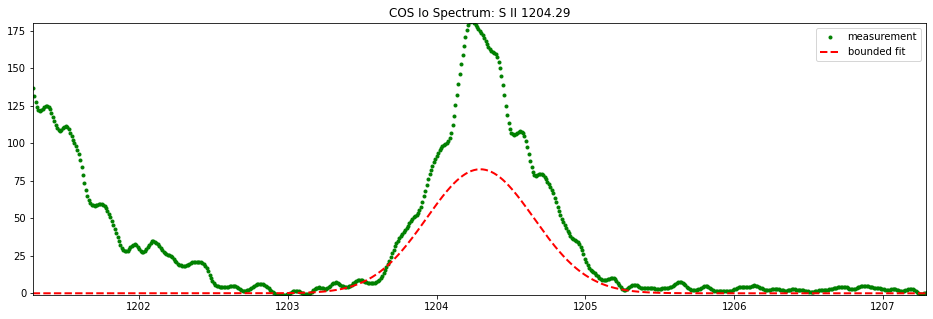

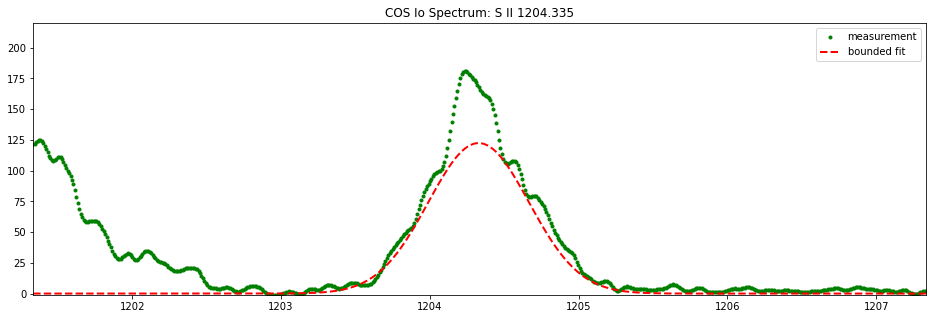

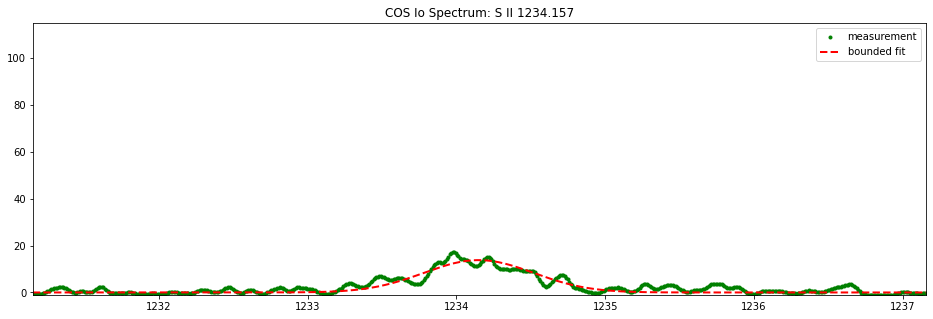

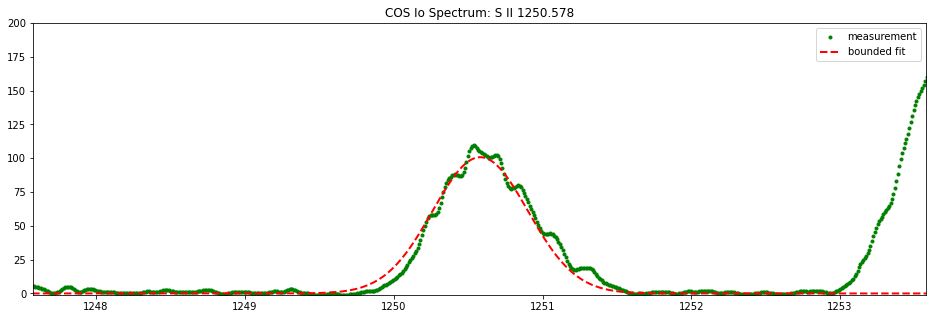

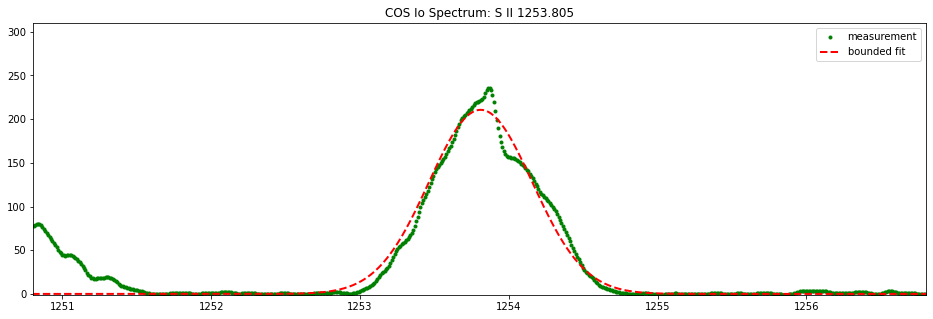

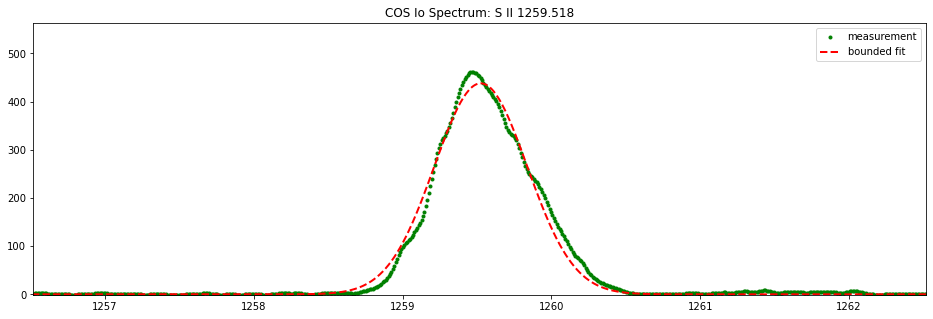

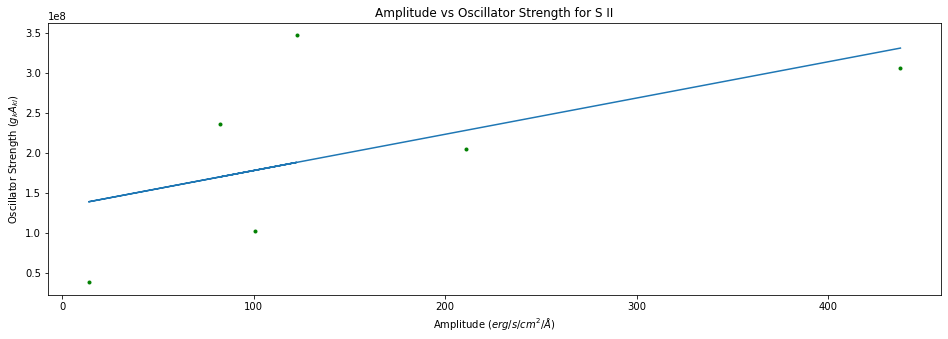

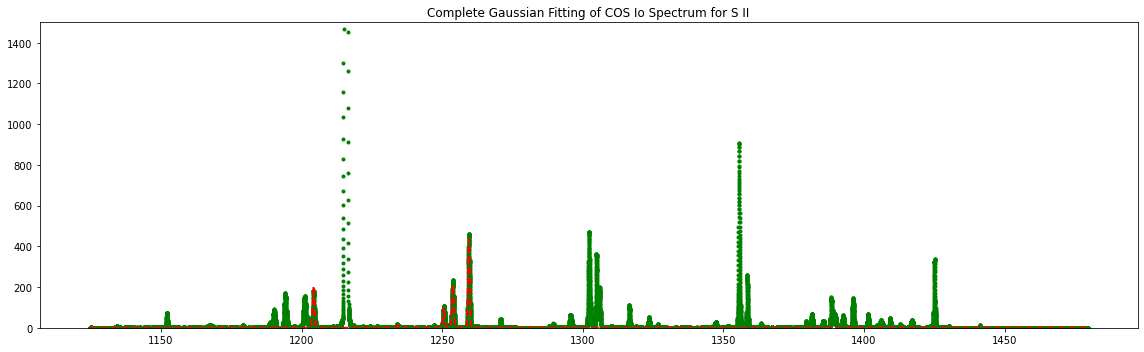

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


<Figure size 432x288 with 0 Axes>

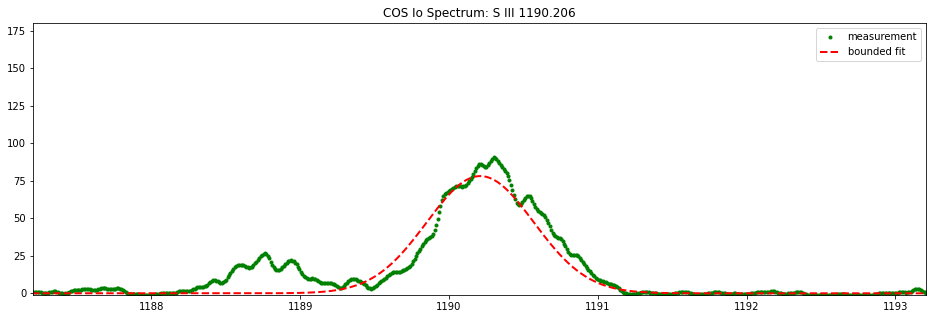

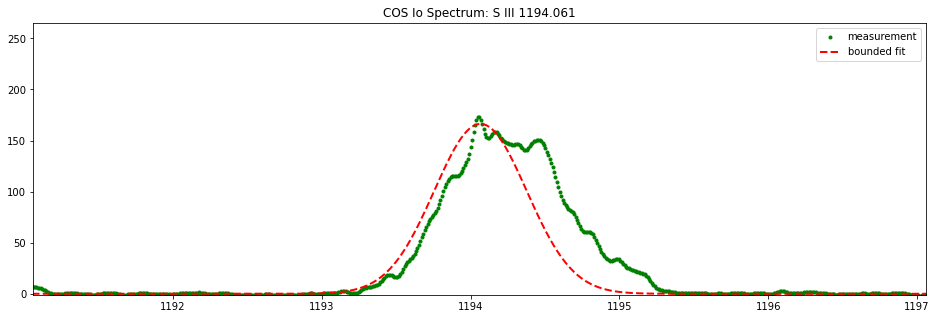

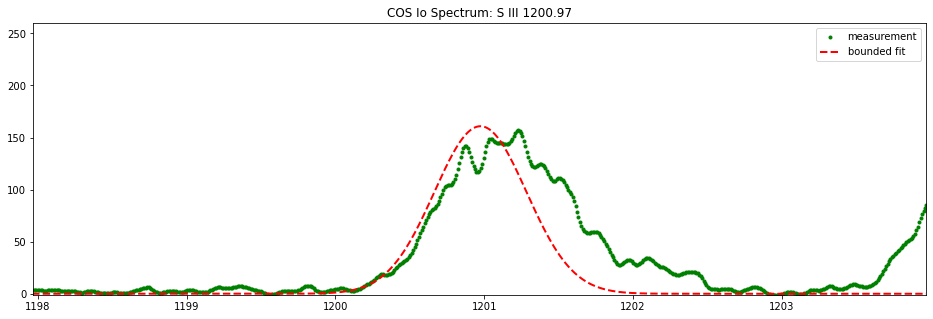

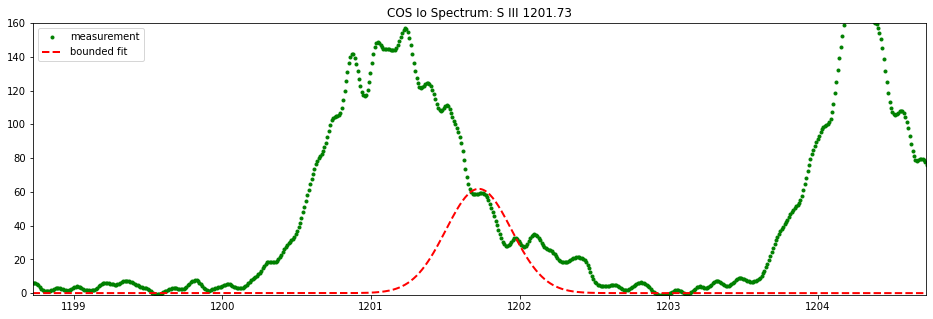

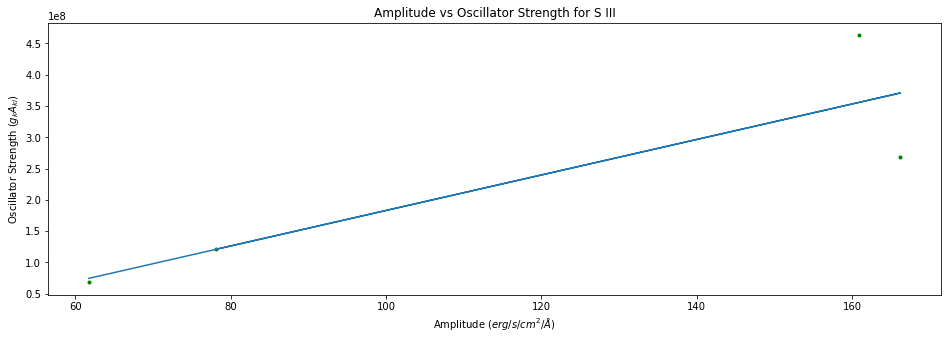

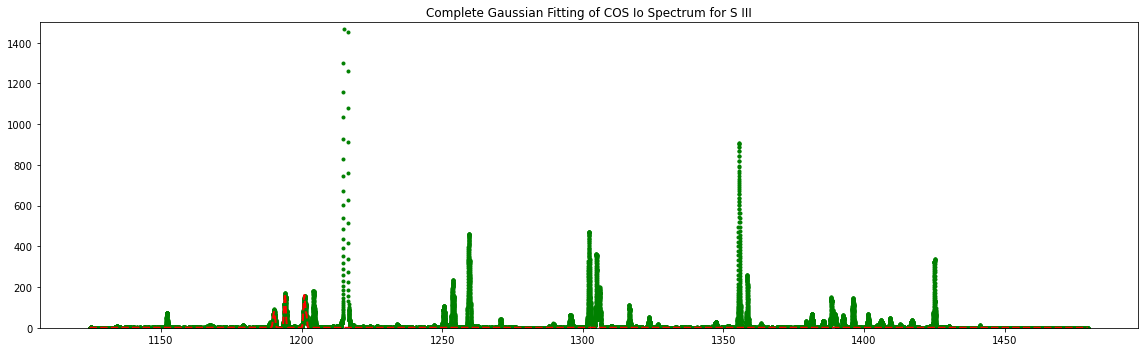

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.01it/s]


<Figure size 432x288 with 0 Axes>

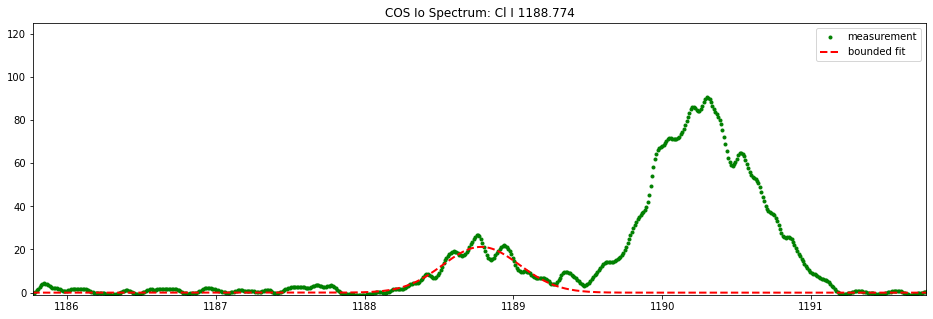

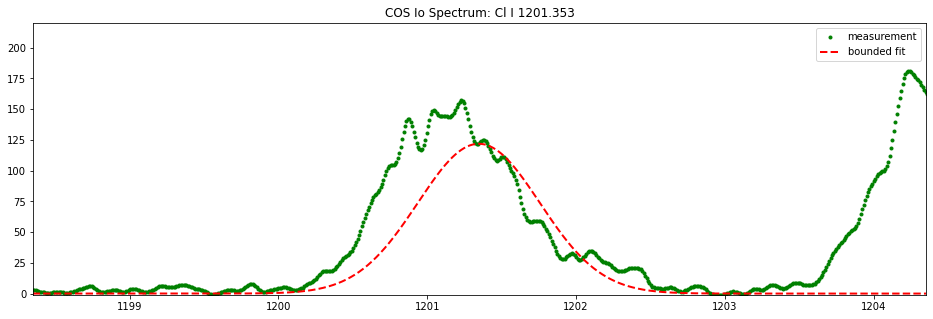

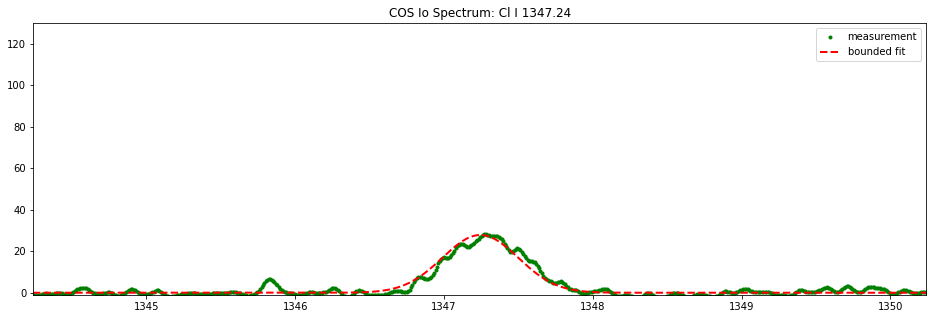

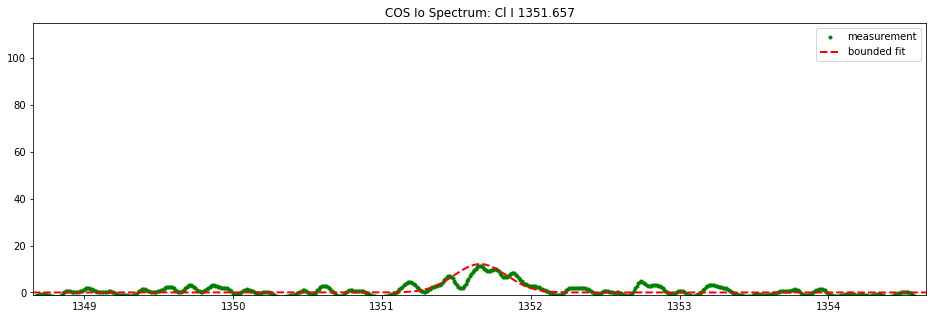

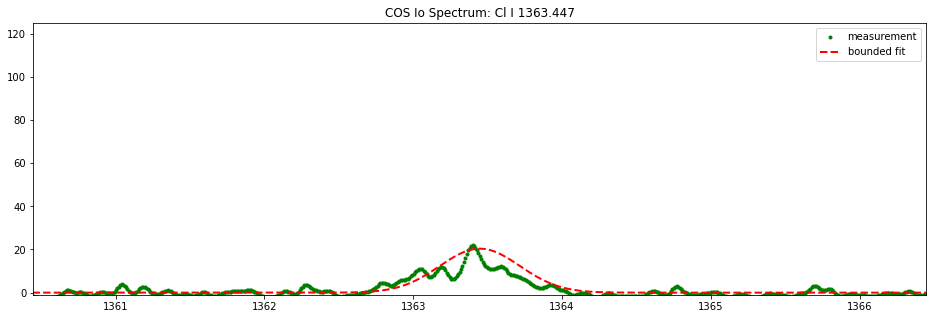

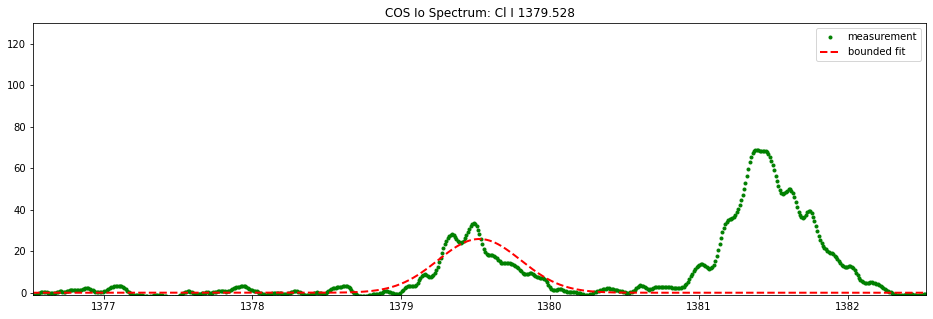

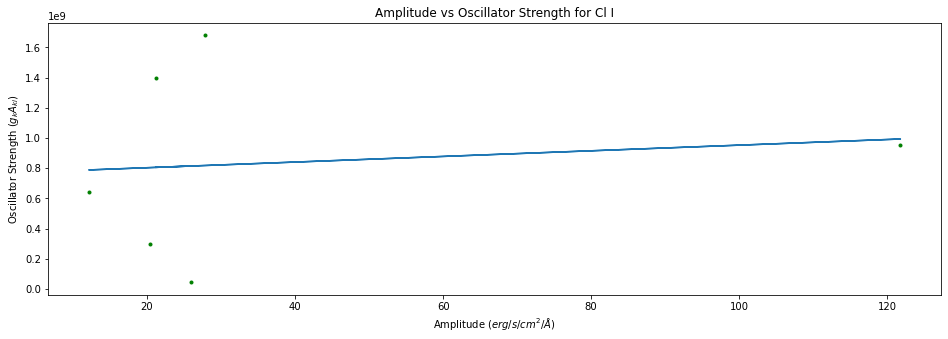

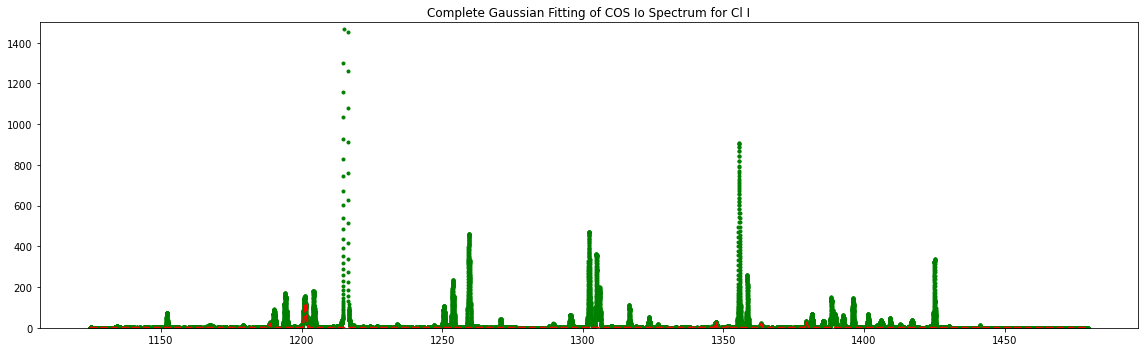

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


<Figure size 432x288 with 0 Axes>

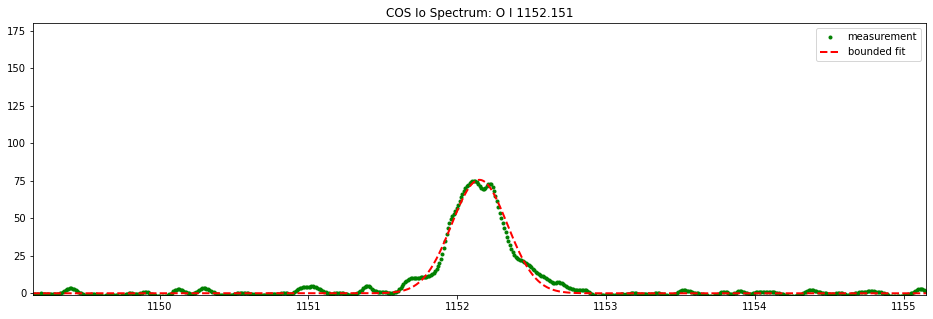

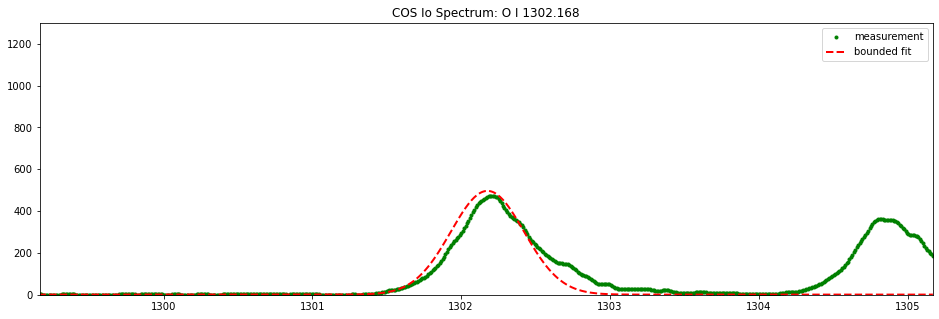

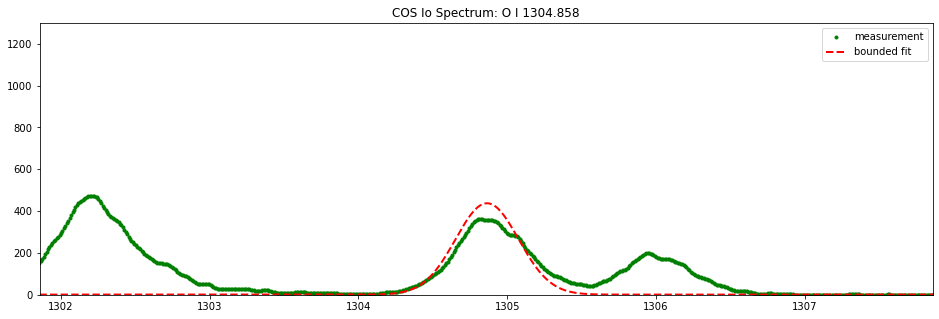

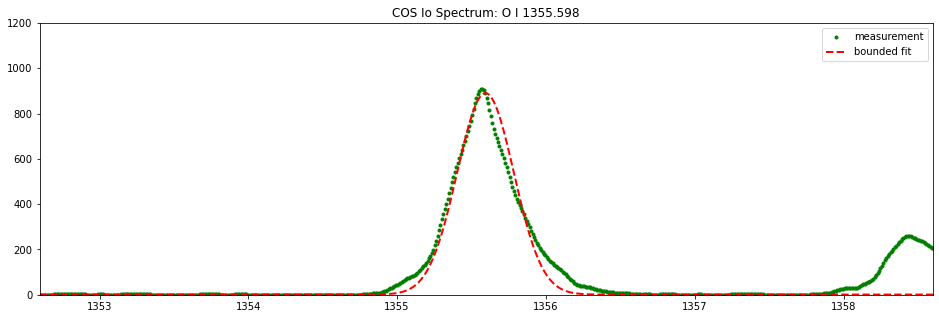

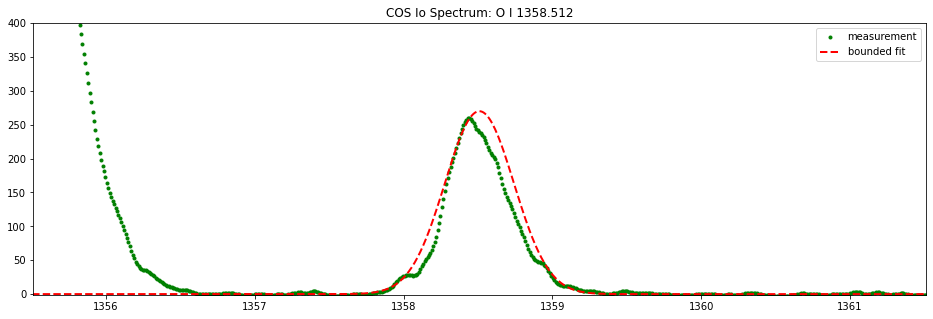

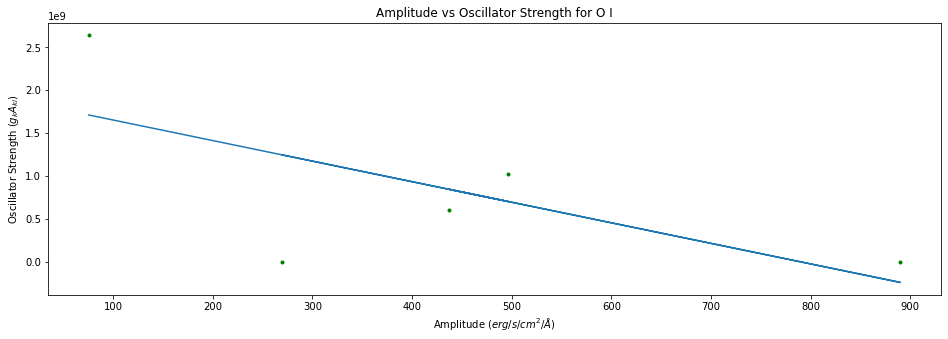

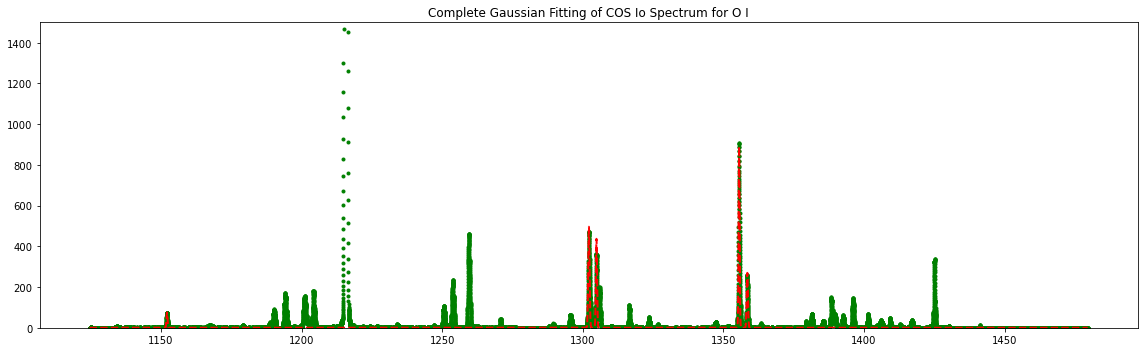

<Figure size 432x288 with 0 Axes>

In [4]:
%matplotlib inline
for i in range(0,len(lines)):
    line = lines[i]
    test,array_line = target_array(line)
    params = fit_whole_spectra(test)
    species_plot(line)
    full_plot_per_species()
    total_params = np.vstack((total_params,params))
    a = (len(params))
    length.append(a)

<IPython.core.display.Javascript object>


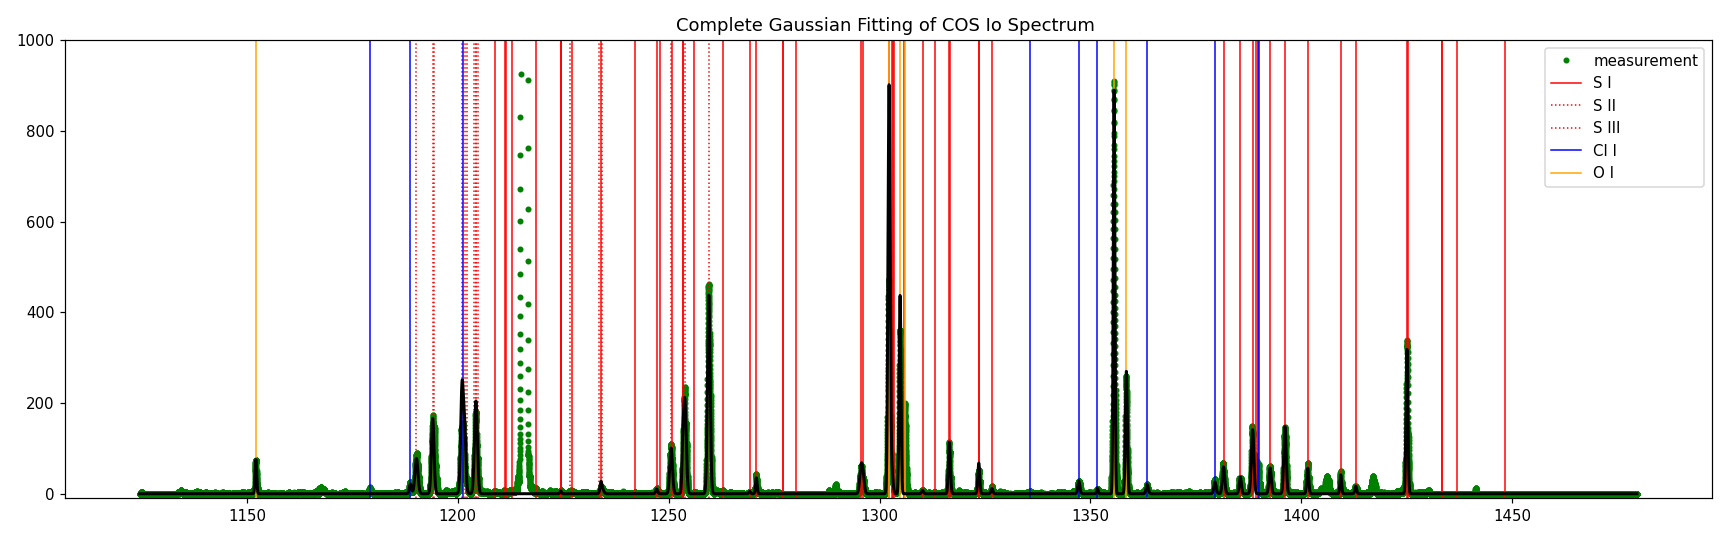

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt
total_spectrum_plot(total_params, c='black')
plt.show()
save_place = '/Users/jojoa/GitHub/io_brightness/data/figures/total_gauss/'

<IPython.core.display.Javascript object>


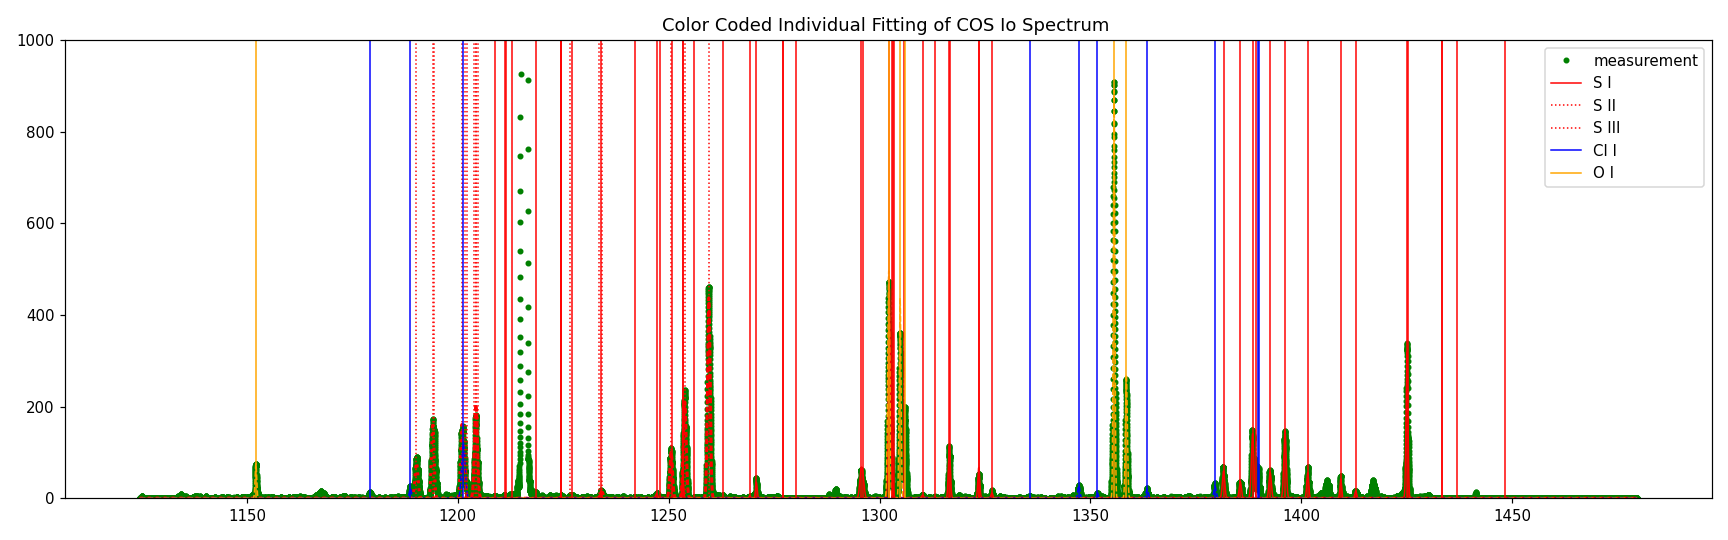

In [6]:
df_wavelength = array['Wavelength']
color_change(total_params)

In [7]:
b = brightness(total_params)

<IPython.core.display.Javascript object>


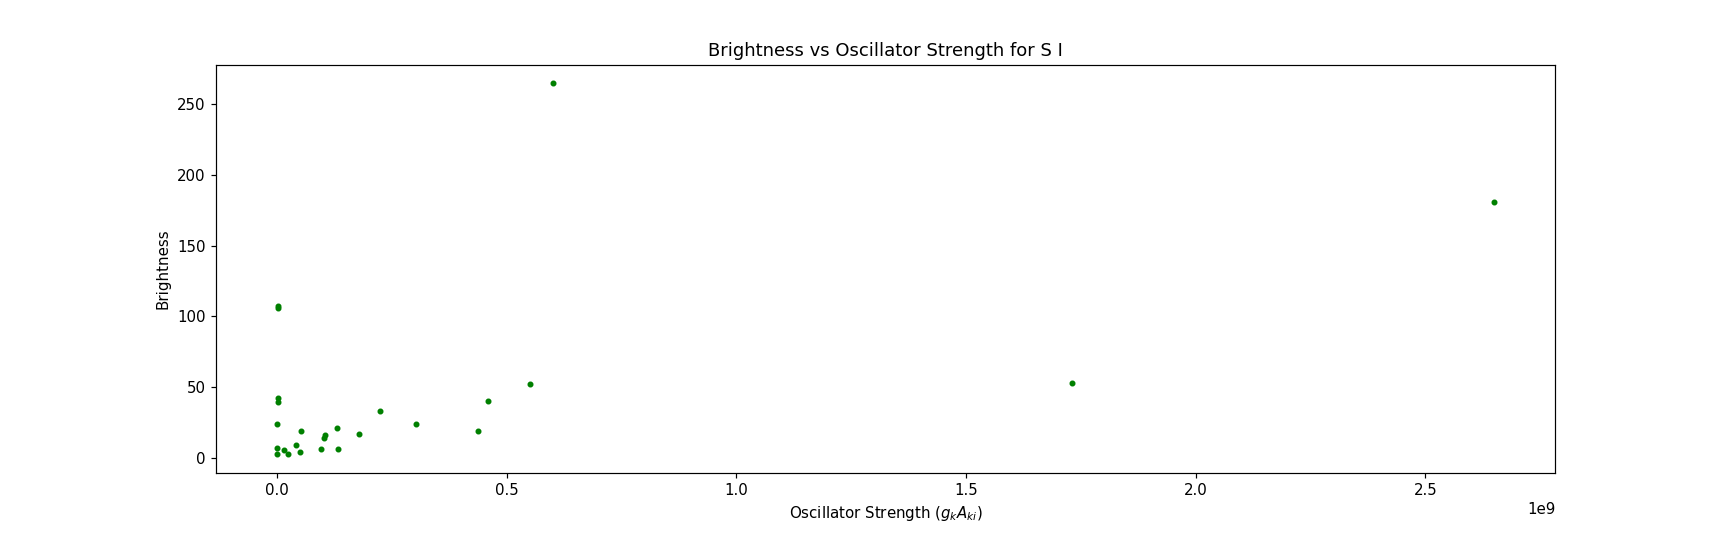

<IPython.core.display.Javascript object>


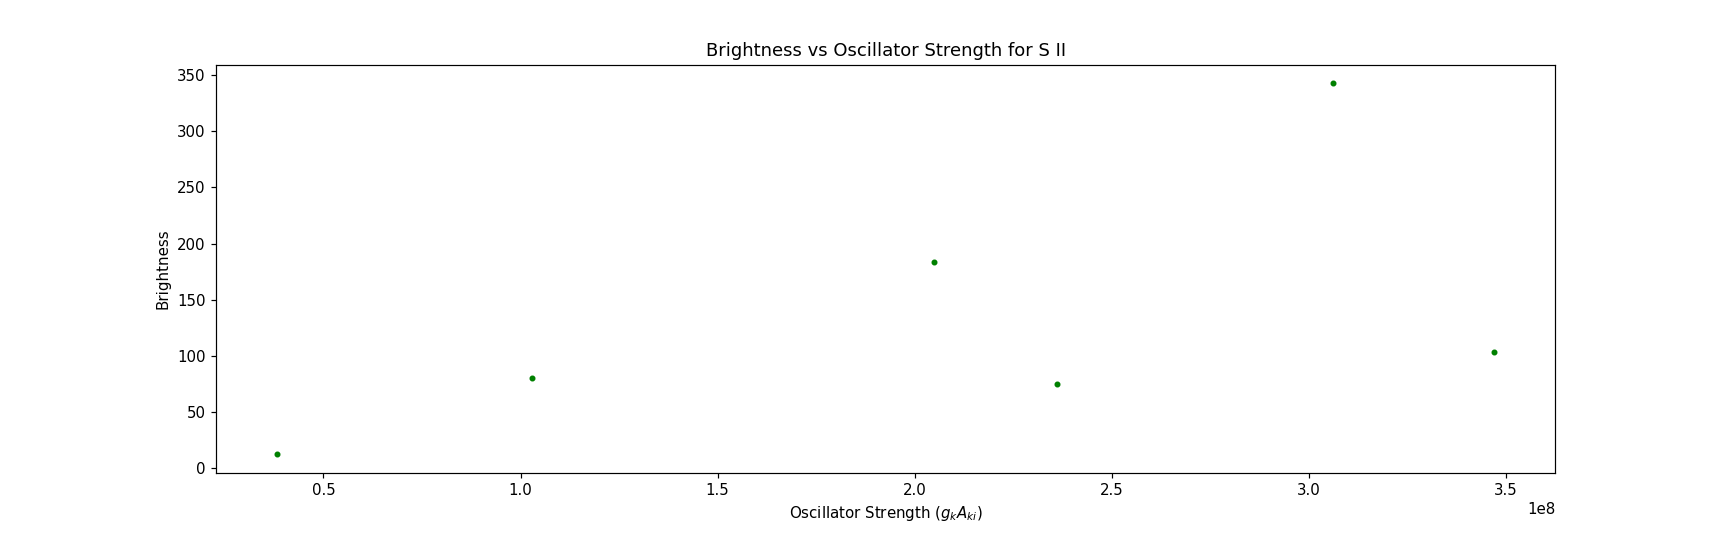

<IPython.core.display.Javascript object>


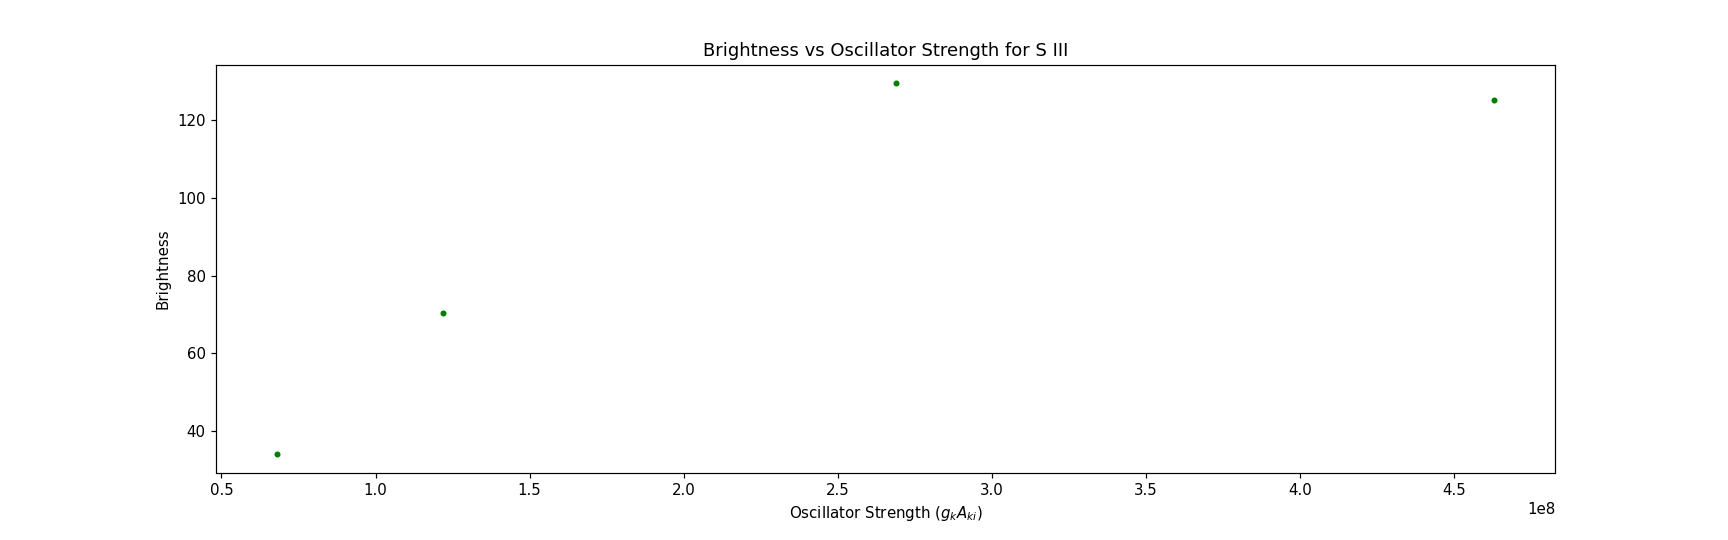

<IPython.core.display.Javascript object>


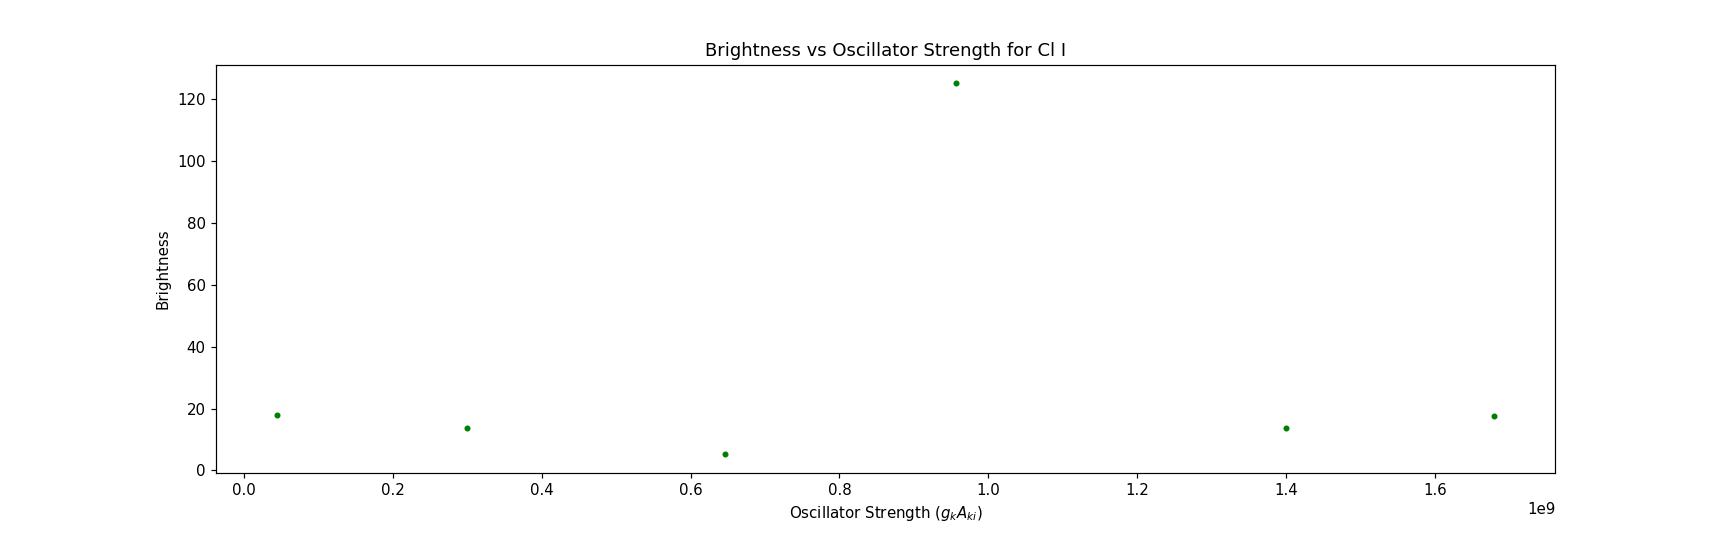

<IPython.core.display.Javascript object>


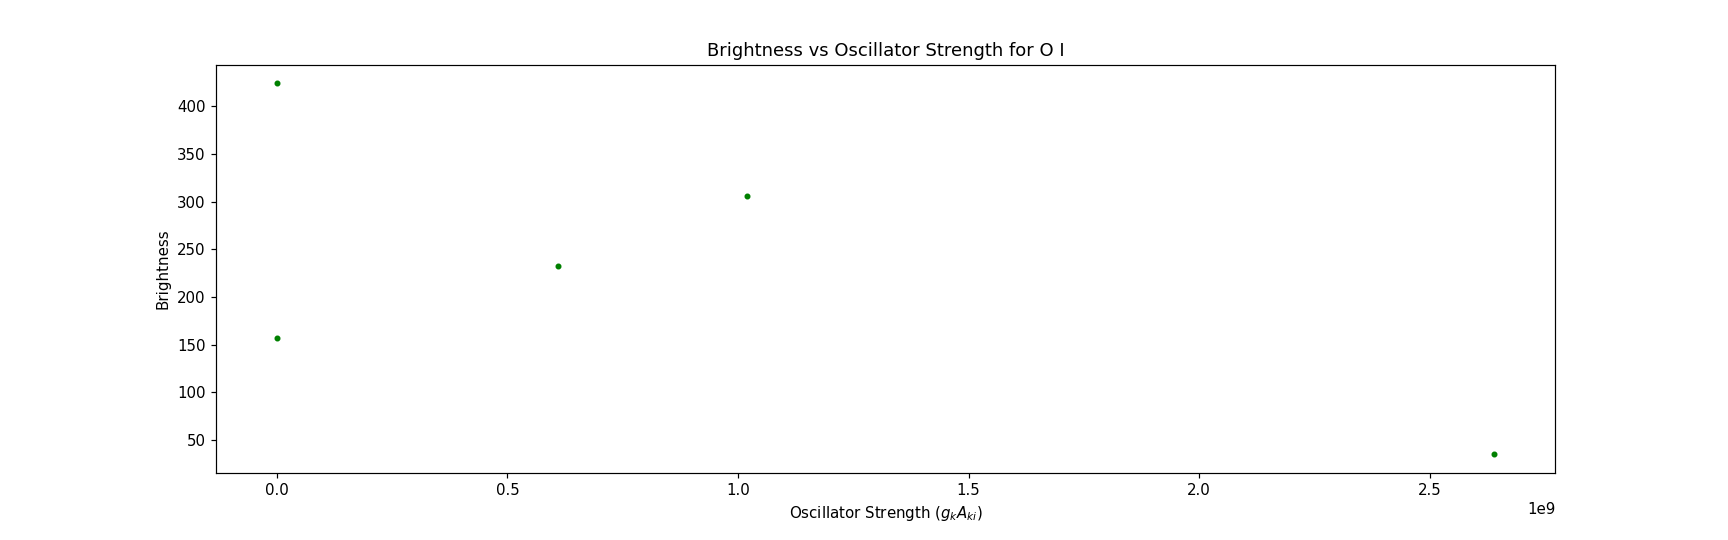

In [9]:
%matplotlib notebook
for i in range(0,len(lines)):
    line = lines[i]
    brightness = b[i]
    test,array_line = target_array(line)
    no_nans = array_line.dropna()
    os = no_nans['Oscillator Strength (gA)']
    os_vs_brightness(os,brightness)